In [1]:
from Basics import *
setplot(dark=True)

from Models import SHMRs, HMFs, HODs, Profiles, SMFs,FFTs, ForwardModel, Measurements

First, start with some cosmological parameters that we'll need to specify throughout

In [ ]:
cpars = {'hh': 0.7, 'Omega_L': 0.75, 'Omega_m': 0.25, 'Omega_b': 0.044, 'T_CMB': 2.726, 'XH':0.76, 'v_rms':1.06e-3}

Then we can create a dictionary to specify the data we want to load in

In [6]:
tszdict = {'Data': {'name':'Schaan2021', 'spefs': {}}}
kszdict = {'Data': {'name':'Schaan2021', 'spefs': {}}}

tSZdata = getattr(Measurements, tszdict['Data']['name'])(tszdict['Data']['spefs'])
kSZdata = getattr(Measurements, kszdict['Data']['name'])(kszdict['Data']['spefs'])

Now let's start with defining the model. We'll need some basic cosmological functions, so let's just fetch those from astropy

In [7]:
cosmology = astropy.cosmology.LambdaCDM(H0=cpars["hh"]*100, Tcmb0=cpars['T_CMB'], Om0=cpars["Omega_m"], Ode0=cpars["Omega_L"], Ob0=cpars["Omega_b"])

H_func = lambda z: cosmology.H(z).to(u.km/u.s/u.Mpc).value
rhoc_func = lambda z: cosmology.critical_density(z).to(u.Msun/u.Mpc**3).value
dA_func = lambda z: cosmology.angular_diameter_distance(z).value
r200c_func = lambda z, logm200c: (10**logm200c/(4/3*np.pi*200*rhoc_func(z)[:, None]))**(1/3)

The forward model will also need the following which are more complicated:
- halo mass function
- te stellar mass function 
- stellar-halo mass relation
- halo occupancy distrbution (only if doing it through this method)

all of which are entirely defined in their respective files and simple need to be called and specified.


In [21]:
fmoddict = {
    'HMF': {'name':'pyccl', 'spefs': {'mfunc':'Tinker08', 'mdef':'200c', 'hbias': 'Tinker10'}},
    'HOD': {'name':'Kou2023', 'spefs': {'sample':'M*>10.8'}},
    'SMF': {'name': 'BOSSDR10', 'spefs': {'galaxy':'CMASS','group':'portsmouth', 'template':'passive', 'IMF':'Kroupa'}},
    'SHMR': {'name': 'Kravstov2014', 'spefs': {'sample': 'M200c'}},
}

hod = getattr(HODs, fmoddict['HOD']['name'])(fmoddict['HOD']['spefs'])
shmr = getattr(SHMRs, fmoddict['SHMR']['name'])(fmoddict['SHMR']['spefs'])
smf = getattr(SMFs, fmoddict['SMF']['name'])(fmoddict['SMF']['spefs'])
hmod = getattr(HMFs, fmoddict['HMF']['name'])(fmoddict['HMF']['spefs'])

We'll want to set more stringent liimits on our things before deifning them furhter

In [118]:
mrange = (SMF.logmstar<=SHMR.HSMR(14))
zrange = (SMF.z>=0.4) & (SMF.z<=0.7)

zs, logmstar = SMF.z[zrange], SMF.logmstar[mrange]
SMF_N = SMF.N[zrange][:, mrange]
dndlogmstar = SMF.dndlogmstar(**cpars)[zrange][:, mrange]

In [119]:
logmhalo = SHMR.SHMR(logmstar)
logmhalo = np.arange(logmhalo[0], logmhalo[-1], (logmhalo[-1]-logmhalo[0])/logmhalo.size)

dndlogmhalo = hmod.HMF(zs, logmhalo, **cpars)

In [121]:
rs = np.logspace(-1.5, 1.5, 100)

With all the componenents loaded in, we can now develop the actual forward modeling parts

In [152]:
SMF_N_halo = np.array([np.interp(logmhalo, SHMR.SHMR(logmstar), SMF_N[i, :]) for i in range(zs.size)])

ave_weight = ForwardModel.weighting(SMF_N_halo)
# ave_weight2 = lambda Pths: np.sum(np.trapz(Pths*dndlogmstar, logmstar), axis=1)/np.sum(np.trapz(dndlogmstar, logmstar))
# ave_weight3 = lambda Pths: np.trapz(np.trapz(Pths*dndlogmstar/SMF.dz, logmstar), zs)/np.trapz(np.trapz(dndlogmstar/SMF.dz, logmstar), zs)

# plt.loglog(rs, ave_weight3(Pth()), alpha=0.5)
# plt.loglog(rs, ave_weight2(Pth()), alpha=0.5)
# plt.loglog(rs, ave_weight(Pth()), alpha=0.5)
# plt.loglog(rs, Pth()[:, 25, 10], alpha=0.5)

In [153]:
zave = np.sum(np.trapz(zs[:,None]*dndlogmstar, logmstar))/np.sum(np.trapz(dndlogmstar, logmstar))

tSZproj = ForwardModel.project_Hankel(rs, tSZdata.thetas, dA_func(zave), tSZdata.beam_data, tSZdata.beam_ells, tSZdata.resp_data, tSZdata.resp_ells)
tSZsign = ForwardModel.Pth_to_muK(freq=tSZdata.freq, **cpars)

kSZproj = ForwardModel.project_Hankel(rs, kSZdata.thetas, dA_func(zave), kSZdata.beam_data, kSZdata.beam_ells, kSZdata.resp_data, kSZdata.resp_ells)
kSZsign = ForwardModel.rho_to_muK(freq=kSZdata.freq, **cpars)

We define our profiles, both the one-halo and two-halo component, and then sum to get the total. These can also be replaced with any input array of profile, so long as it matches the formatting and mass/redshift dimensionalities.

In [154]:
Pthdict = {'onehalo': {'name':'Amodeo2021', 'spefs': {'model':'GNFW'}},
            'twohalo': {'name':'Amodeo2021', 'spefs': {'model':'GNFW'}},
    }

rhodict = {'onehalo': {'name':'Amodeo2021', 'spefs': {'model':'GNFW'}},
            'twohalo': {'name':'Amodeo2021', 'spefs': {'model':'GNFW'}},
    }

In [155]:
# Define a pressure and density profile
Pth1h = getattr(Profiles, Pthdict['onehalo']['name'])(Pthdict['onehalo']['spefs']).Pth1h(rs, zs, logmhalo, rhoc_func, r200c_func, **cpars)
Pth2h = getattr(Profiles, Pthdict['twohalo']['name'])(Pthdict['twohalo']['spefs']).Pth2h(rs, zs, logmhalo, rhoc_func, r200c_func, hmod.Plin, hmod.bh, hmod.HMF, **cpars)
Pth = lambda params={}: Pth1h(params)+Pth2h(params)

rho1h = getattr(Profiles, rhodict['onehalo']['name'])(rhodict['onehalo']['spefs']).rho1h(rs, zs, logmhalo, rhoc_func, r200c_func, **cpars)
rho2h = getattr(Profiles, rhodict['twohalo']['name'])(rhodict['twohalo']['spefs']).rho2h(rs, zs, logmhalo, rhoc_func, r200c_func, hmod.Plin, hmod.bh, hmod.HMF, **cpars)
rho = lambda params={}: rho1h(params)+rho2h(params)

Now with all of our forward model functions defined, the process of going from any input profile is simple and easy, and only dependent on some input parameters that define that profile.

In [128]:
rhos_sim = np.array([0.00000000e+00, 0.00000000e+00, 3.23705634e-27, 1.56168858e-27,
       4.91244157e-27, 5.21580669e-27, 6.38216246e-27, 5.70257482e-27,
       4.12217423e-27, 2.33994805e-27, 1.27096728e-27, 8.04106407e-28,
       3.44132275e-28, 2.88597645e-28, 1.87161756e-28, 2.24149017e-28,
       2.29002389e-28, 2.29382382e-28, 2.43134868e-28, 1.86100842e-28,
       2.86294376e-28, 1.81634456e-28, 2.16678369e-28, 2.19674323e-28,
       2.36151784e-28, 2.43873184e-28, 1.41361124e-28, 1.41445148e-28,
       1.22321137e-28, 1.06014661e-28, 7.01056510e-29, 4.03953593e-29,
       3.15549963e-29, 2.17803688e-29, 1.68568303e-29, 1.13405189e-29,
       7.89355462e-30, 4.38655348e-30, 3.12446110e-30, 2.37524525e-30,
       1.97745749e-30, 2.14973063e-30, 3.32091724e-30, 1.93460365e-30,
       2.53382894e-30, 2.02206927e-30, 1.54370781e-30, 1.35169049e-30,
       1.34329254e-30, 1.20058152e-30])

pths_sim = np.array([0.00000000e+00, 0.00000000e+00, 2.05314805e-12, 6.94251223e-13,
       2.86421140e-12, 1.97639960e-12, 6.43160187e-12, 1.77639342e-12,
       2.20108092e-12, 6.59821541e-13, 5.43241396e-13, 7.55490390e-14,
       9.40319103e-14, 4.08399105e-14, 3.33190822e-14, 3.19031824e-14,
       5.08679567e-14, 4.13141708e-14, 5.63702278e-14, 5.07182323e-14,
       6.17000004e-14, 6.61052150e-14, 7.84620564e-14, 8.55376704e-14,
       7.64423241e-14, 5.40675911e-14, 3.72300205e-14, 3.23169410e-14,
       2.76731905e-14, 2.17792175e-14, 1.32490948e-14, 6.96784790e-15,
       4.42343723e-15, 2.97184146e-15, 2.16026921e-15, 1.36124006e-15,
       7.54415868e-16, 4.46554217e-16, 3.38613867e-16, 2.70582907e-16,
       2.05932028e-16, 1.70437833e-16, 3.96481946e-16, 2.00107734e-16,
       4.35852463e-16, 1.94587114e-16, 8.98226433e-17, 1.35380278e-16,
       2.02366497e-16, 7.82287119e-17])

rs_sim = np.array([0.00490767, 0.00563476, 0.00646957, 0.00742806, 0.00852855,
       0.00979209, 0.01124282, 0.01290849, 0.01482093, 0.0170167 ,
       0.01953778, 0.02243238, 0.02575582, 0.02957163, 0.03395278,
       0.03898301, 0.04475848, 0.05138961, 0.05900317, 0.0677447 ,
       0.07778132, 0.08930491, 0.10253575, 0.1177268 , 0.13516845,
       0.15519414, 0.17818671, 0.20458572, 0.23489584, 0.26969651,
       0.30965302, 0.35552924, 0.40820218, 0.46867881, 0.53811528,
       0.617839  , 0.70937409, 0.81447043, 0.93513717, 1.07368113,
       1.23275088, 1.41538739, 1.62508215, 1.86584396, 2.1422755 ,
       2.45966137, 2.82406911, 3.24246518, 3.72284814, 4.27440157])

rhos_sim = np.interp(rs, rs_sim, rhos_sim, right=0)
pths_sim = np.interp(rs, rs_sim, pths_sim, right=0)

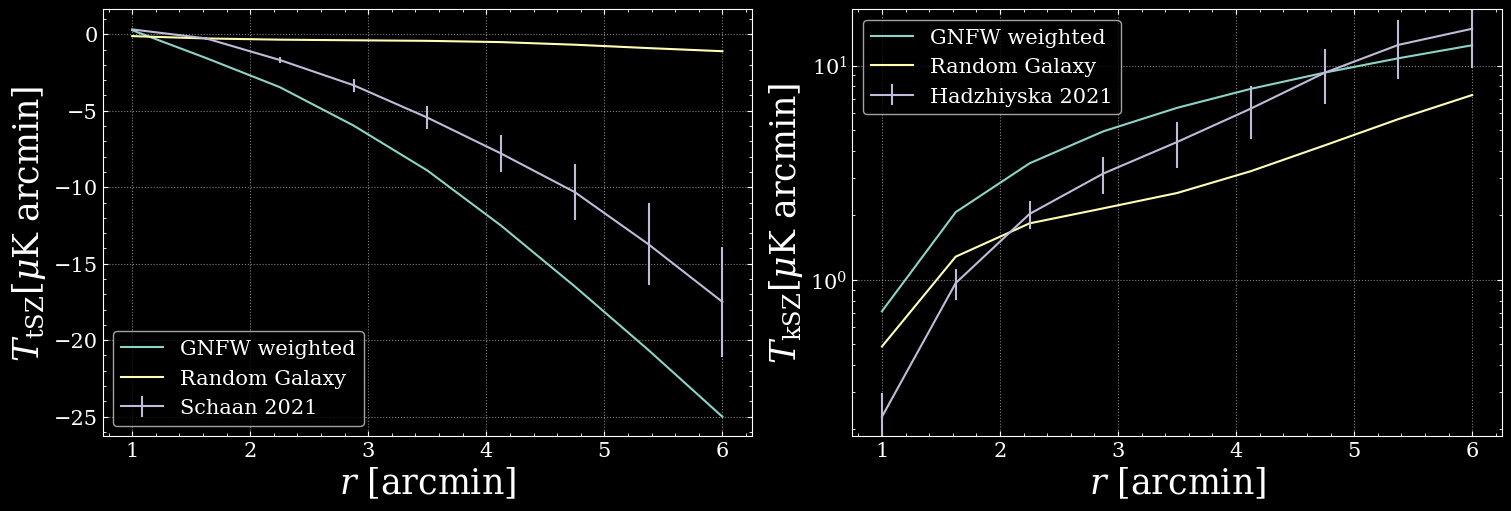

In [157]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')
axs[0].set(xlabel=r'$r$ [arcmin]', ylabel=r'$T_\text{tSZ} [\mu \text{K arcmin}]$')
axs[1].set(xlabel=r'$r$ [arcmin]', ylabel=r'$T_\text{kSZ} [\mu \text{K arcmin}]$', yscale='log')

# axs[0].plot(tSZdata.thetas, tSZsign(tSZproj(ave_HOD(Pth({'P0':1, 'beta_t':3.5}), cpars)))+tSZdata.dustprof, label='GNFW HOD')
axs[0].plot(tSZdata.thetas, tSZsign(tSZproj(ave_weight(Pth())))+tSZdata.dustprof, label='GNFW weighted')
axs[0].plot(tSZdata.thetas, tSZsign(tSZproj(pths_sim)), label='Random Galaxy')
axs[0].errorbar(tSZdata.thetas, tSZdata.tSZdata, np.diag(tSZdata.tSZcov)**0.5, label='Schaan 2021')

# axs[1].plot(kSZdata.thetas, kSZsign(kSZproj(ave_HOD(rho(), cpars))), label='GNFW HOD')
axs[1].plot(kSZdata.thetas, kSZsign(kSZproj(ave_weight(rho()))), label='GNFW weighted')
axs[1].plot(kSZdata.thetas, kSZsign(kSZproj(rhos_sim)), label='Random Galaxy')
axs[1].errorbar(kSZdata.thetas, kSZdata.kSZdata, np.diag(kSZdata.kSZcov)**0.5, label='Hadzhiyska 2021')


axs[0].legend(), axs[1].legend(); plt.show()